# Determining the cause of inconsistent onset-season trends in the Northern Hemisphere snow cover extent record

This Jupyter Notebook contains code to reproduce most of the figures in Elias Chereque et al. (2025). It is shared alongside processed datasets and the pre-processing scripts that generate them. Headers and sections delineate different steps of the analysis.

In [ ]:
# Import statements

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kendalltau, linregress
import pandas as pd
from scipy.optimize import curve_fit
import os

import sys
sys.path.append(os.environ['HOME'] + '/L0_Aux/')
from subsample_weight_and_timeav_like_NOAA import subsample_weight_and_timeav_like_NOAA

import matplotlib as mpl

The main package we use to work with netcdf files is xarray. Statistical tests are implemented with scipy.stats functions. We also use a custom function ```subsample_and_timeav_like_NOAA``` which yields the average snow using the validity dates of the NOAA CDR and weighting for each week using the number of days it overlaps with the month in question.

We set up one colormap for all figures and also define some look-up tables for month names and colours to be used throughout the code.

In [3]:
### /// Settings for figures /// ###
cmap = mpl.colormaps.get_cmap('plasma').resampled(38)
norm = mpl.colors.Normalize(vmin=0, vmax=15)

### /// LUT for month names, colours, etc. /// ###
mname = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
colours = {'ERA5':'C0', 'MERRA2':'C2', 'JRA55':'C1'}
d_f_dict = {'ERA5':'BrE5', 'MERRA2':'BrM2', 'JRA55':'BrJ55'}

# Figure 1 -- Various fixed thresholds

In this section, we produce a comparison between satellite data (NOAA CDR) and B-TIM-derived snow cover extent. 

<>:29: SyntaxWarning: invalid escape sequence '\,'
<>:29: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_785369/3747974442.py:29: SyntaxWarning: invalid escape sequence '\,'
  label=d_f_dict[model] + '$_{\,NOAA}$',


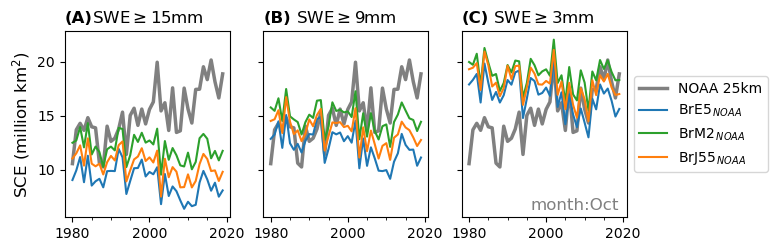

In [ ]:
### /// Setup /// ###
letters = iter(['(A)', '(B)', '(C)', '(D)', '(E)', '(F)'])

month=10
mstr = str(month).zfill(2)
thresholds_to_plot = [15, 9, 3] #mm

fig, axs = plt.subplots(figsize=(7.25,3*7.25/9), ncols=3, nrows=1, sharey=True)

### /// Load and plot data /// ###
for mc, model in [i.split('.') for i in ['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']]:
        
        data_loc = os.environ['HOME'] + '/L3_Final/'
        ds = xr.open_dataset(data_loc + f'{mc}.{model}.reanalysis.weekly.scf_agreements.40N_90N.{mstr}.2.nc')
        
        ds = subsample_weight_and_timeav_like_NOAA(ds, month)

        for nt, tval in enumerate(thresholds_to_plot):
            if model == 'ERA5':
                ### Plot NOAA 
                ### Convert units to million km2, using the fact that grid is 25km EASE grid
                ((ds.both + ds.not_BTIM)*25*25/1e6).sum(dim='region').sel(threshold=3).plot(ax=axs[nt],
                                                                                            color='grey', 
                                                                                            linewidth=2.5,
                                                                                            label='NOAA 25km')
            
            ### Plot BTIM, convert units
            ((ds.both + ds.not_NOAA)*25*25/1e6).sum(dim='region').sel(threshold=tval).plot(ax=axs[nt], 
                                                                                           label=d_f_dict[model] + '$_{\,NOAA}$', 
                                                                                           color=colours[model])

### /// Decorate axes /// ###
for nt,tval in enumerate(thresholds_to_plot):
    axs[nt].set_ylabel('')
    axs[nt].set_xlabel('')
    axs[nt].set_xticks(range(1980, 2021, 5), minor=True)
    axs[nt].set_title(next(letters), loc='left', fontweight='bold')
    axs[nt].set_title(r'SWE$\geq$'+str(tval)+'mm')
    
axs[0].set_ylabel('SCE (million km$^2$)', fontsize='large')
plt.text(0.95, 0.025, 'month:'+str(mname[month]), fontsize='large', ha='right', va='bottom', color='grey', transform=axs[2].transAxes)
axs[2].legend(bbox_to_anchor=(1, 0.5), loc='center left')

plt.savefig('Fig1.png', bbox_inches='tight', dpi=300)

plt.show()

## Supplementary figures: cross-dataset correlations

- [x] Same forcing: how similar are the SCE time series across thresholds (Kendall-tau test, with p-value of 0.025)
- [x] Compare to NOAA CDR: for a fixed threshold, how do SCE time series compare to the NOAA reference dataset (Kendall-tau test, p-value of 0.025)
- [x] Cross pairs: for a fixed threshold, how do SCE time series compare across B-TIM datasets (Kendall-tau test, p-value of 0.025)
- [x] Set of min/max snow years after detrending

In [8]:
### /// Function to remove linear trend /// ###
def remove_lin(df):

    try:
        x = df.index.get_level_values(1).values
    except IndexError:
        x = df.index.values
    
    try:
        popt, pcov = curve_fit(lambda x,a,b: a*x+b, x, df['Area'])
        return df['Area'].droplevel('threshold') - (popt[0]*x + popt[1])
    except:
        popt, pcov = curve_fit(lambda x,a,b: a*x+b, x, df)
        return df - (popt[0]*x + popt[1])

######40N_90N#######


,NOAA-ERA5,NOAA-MERRA2,NOAA-JRA55
Threshold[mm],,,
1,0.441,0.497,0.500
3,0.472,0.528,0.500
5,0.464,0.518,0.513
7,0.456,0.495,0.485
9,0.421,0.487,0.459
11,0.379,0.449,0.428
13,0.367,0.431,0.395
15,0.336,0.410,0.356


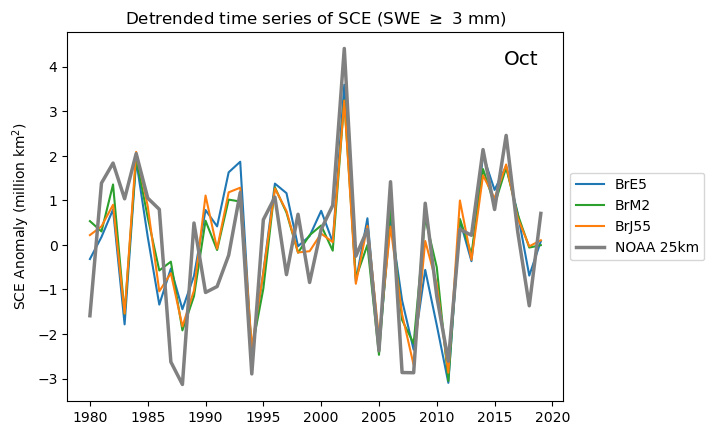

Threshold[mm],E5-M2,J55-E5,J55-M2
1,0.774,0.859,0.864
3,0.800,0.849,0.859
5,0.762,0.803,0.867
7,0.797,0.828,0.841
9,0.744,0.808,0.818
11,0.741,0.797,0.867
13,0.741,0.813,0.846
15,0.756,0.810,0.818


In [ ]:
### /// Setup for detrending /// ###
month = 10
lmm_str = '40N_90N'
mstr = str(month).zfill(2)

### /// Calculate and display statistics /// ###
print(lmm_str.center(20, '#'))

NOAA_df = pd.DataFrame(index=[1,3,5,7,9,11,13,15])
NOAA_df.index.name = 'Threshold[mm]'

for mc, model in [i.split('.') for i in ['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']]:
    ### /// Load, weight, calculate monthly average /// ###
    vars()[model] = xr.open_dataset(os.environ['HOME'] + '/L3_Final/{mc}.{model}.reanalysis.weekly.scf_agreements.{lmm_str}.{mstr}.2.nc')
    vars()[model] = subsample_weight_and_timeav_like_NOAA(vars()[model], month, ylim=[1980, 2020]).sum(dim='region') * 25 * 25 / 1e6 # million km2

    ### /// Detrend NOAA dataset /// ###
    NOAA_detrended = ((vars()[model].both + vars()[model].not_BTIM).to_dataset(name="Area").to_dataframe().groupby('threshold').apply(remove_lin).T)
    
    ### /// Detrend BTIM dataset /// ###
    vars()[model] = vars()[model].both + vars()[model].not_NOAA
    vars()[model + '_detrended'] = vars()[model].to_dataset(name="Area").to_dataframe().groupby('threshold').apply(remove_lin).T
    vars()[model + '_detrended'][3].plot(label=d_f_dict[model], color=colours[model])

    ### /// Compare both /// ###
    stat_vals = []
    for j in [1,3,5,7,9,11,13,15]:

        ktstat=kendalltau(NOAA_detrended[j], vars()[model + '_detrended'][j])
        stat_vals.append([ktstat.statistic if ktstat.pvalue<=0.025 else np.nan][0])
        
    NOAA_df['NOAA-'+model] = pd.Series(stat_vals, index = [1,3,5,7,9,11,13,15])

display(NOAA_df.style.background_gradient(axis=None, vmin=0.35, vmax=0.55, cmap="Reds").format(precision=3))

### /// Plot one threshold detrended /// ###
NOAA_detrended[3].plot(color='grey', 
                linewidth=2.5,
                label='NOAA 25km')
plt.ylabel(r'SCE Anomaly (million km$^{2}$)')
plt.xlabel('')
plt.title(r'Detrended time series of SCE (SWE $\geq$ 3 mm)')
plt.text(0.95, 0.95, mname[month], ha='right', va='top', transform=plt.gca().transAxes, fontsize='x-large')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

### /// Compare cross-forcing pairs for a range of thresholds /// ###
df = pd.DataFrame(index=pd.Series(['E5-M2','J55-E5', 'J55-M2', ], name='Pair'))
for t in [1,3,5,7,9,11,13,15]:
    values = []
    values.append(kendalltau(ERA5_detrended[t], MERRA2_detrended[t]).statistic)
    values.append(kendalltau(JRA55_detrended[t], ERA5_detrended[t]).statistic)
    values.append(kendalltau(JRA55_detrended[t], MERRA2_detrended[t]).statistic)
    df[t] = pd.Series(values, index=pd.Series(['E5-M2','J55-E5', 'J55-M2'], name='Pair'))

df.index.name = 'Threshold[mm]'

### /// Display cross-forcing statistics /// ###
display(df.T.style.background_gradient(axis=None, vmin=0.5, vmax=1, cmap="RdBu_r").format(precision=3))


In [10]:
### /// Setup /// ###
month = 10
lmm_str = '40N_90N'
mstr = str(month).zfill(2)

### /// Calculate and display cross-threshold statistics /// ###
print(lmm_str.center(20, '#'))

for mc, model in [i.split('.') for i in ['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']]:

    df = pd.DataFrame(index=[1,3,5,7,9,11,13,15])

    for i in [1,3,5,7,9,11,13,15]:
        stat_vals = []
        for j in [1,3,5,7,9,11,13,15]:

            ktstat=kendalltau(vars()[model + '_detrended'][i], vars()[model + '_detrended'][j])
            stat_vals.append([ktstat.statistic if ktstat.pvalue<=0.025 else np.nan][0])
            
        df[i] = pd.Series(stat_vals, index = [1,3,5,7,9,11,13,15])

    df.attrs['name'] = model
    print(model)
    display(df.style.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu").format(precision=2))


######40N_90N#######
ERA5


,1,3,5,7,9,11,13,15
1,1.00,0.87,0.80,0.76,0.67,0.62,0.57,0.53
3,0.87,1.00,0.92,0.86,0.75,0.70,0.65,0.61
5,0.80,0.92,1.00,0.95,0.84,0.79,0.73,0.69
7,0.76,0.86,0.95,1.00,0.89,0.84,0.79,0.74
9,0.67,0.75,0.84,0.89,1.00,0.94,0.89,0.84
11,0.62,0.70,0.79,0.84,0.94,1.00,0.95,0.89
13,0.57,0.65,0.73,0.79,0.89,0.95,1.00,0.94
15,0.53,0.61,0.69,0.74,0.84,0.89,0.94,1.00


MERRA2


,1,3,5,7,9,11,13,15
1,1.00,0.87,0.79,0.68,0.60,0.54,0.46,0.42
3,0.87,1.00,0.91,0.78,0.69,0.62,0.54,0.51
5,0.79,0.91,1.00,0.87,0.77,0.71,0.63,0.59
7,0.68,0.78,0.87,1.00,0.90,0.83,0.76,0.71
9,0.60,0.69,0.77,0.90,1.00,0.93,0.85,0.81
11,0.54,0.62,0.71,0.83,0.93,1.00,0.92,0.87
13,0.46,0.54,0.63,0.76,0.85,0.92,1.00,0.94
15,0.42,0.51,0.59,0.71,0.81,0.87,0.94,1.00


JRA55


,1,3,5,7,9,11,13,15
1,1.00,0.88,0.81,0.74,0.65,0.58,0.54,0.47
3,0.88,1.00,0.91,0.82,0.73,0.65,0.61,0.54
5,0.81,0.91,1.00,0.91,0.81,0.73,0.69,0.61
7,0.74,0.82,0.91,1.00,0.90,0.82,0.77,0.69
9,0.65,0.73,0.81,0.90,1.00,0.92,0.87,0.79
11,0.58,0.65,0.73,0.82,0.92,1.00,0.95,0.86
13,0.54,0.61,0.69,0.77,0.87,0.95,1.00,0.91
15,0.47,0.54,0.61,0.69,0.79,0.86,0.91,1.00


In [ ]:
### /// Setup /// ###
month = 10
lmm_str = '40N_90N'
mstr = str(month).zfill(2)

print(lmm_str.center(20, '#'))

### /// Loop over datasets /// ###
loop_n = 0
for mc, model in [i.split('.') for i in ['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']]:
    
    ### /// Load, weight, monthly average /// ###
    vars()[model] = xr.open_dataset(os.environ['HOME'] + '/L3_Final/{mc}.{model}.reanalysis.weekly.scf_agreements.{lmm_str}.{mstr}.2.nc')
    vars()[model] = subsample_weight_and_timeav_like_NOAA(vars()[model], month, ylim=[1980, 2020]).sum(dim='region') * 25 * 25 / 1e6 # million km2
    
    ### /// Detrend NOAA /// ###
    NOAA = ((vars()[model].both + vars()[model].not_BTIM).to_dataset(name="Area").to_dataframe().groupby('threshold').apply(remove_lin).T)
    
    ### /// Detrend dataset /// ###
    vars()[model] = vars()[model].both + vars()[model].not_NOAA
    vars()[model + '_detrended'] = vars()[model].to_dataset(name="Area").to_dataframe().groupby('threshold').apply(remove_lin).T
    
    ### /// Sort by anomaly size (value of SCE after detrending) /// ###
    list_vals = list(zip(vars()[model + '_detrended'][3].values, vars()[model + '_detrended'][3].index.values))
    list_vals.sort(key = lambda x: x[0])

    ### /// Save set of highest anomaly years and lowest anomaly years /// ###
    ### /// Take intersections of sets for overlap /// ###
    max_years = set([i[1].item() for i in list_vals[-10:]])
    min_years = set([i[1].item() for i in list_vals[:10]])

    if loop_n == 0:
        max_all = max_years
        min_all = min_years
    else:
        max_all = max_all & max_years
        min_all = min_all & min_years
    loop_n += 1

### /// Display /// ###
print(mname[month], 'max years (btim only):', sorted(max_all))
print(mname[month], 'min years (btim only):', sorted(min_all))

### /// Display intersection with NOAA anomaly years /// ###
list_vals = list(zip(NOAA[3].values, NOAA[3].index.values))
list_vals.sort(key = lambda x: x[0])

print(mname[month], 'max btim and NOAA:', sorted(max_all & set([i[1] for i in list_vals[-10:]])))
print(mname[month], 'min btim and NOAA:', sorted(min_all & set([i[1] for i in list_vals[:10]])))

######40N_90N#######
Oct max years (btim only): [1984, 1992, 1993, 1996, 2002, 2014, 2015, 2016]
Oct min years (btim only): [1983, 1988, 1994, 2005, 2007, 2008, 2011]
Oct max btim and NOAA: [1984, 1993, 1996, 2002, 2014, 2016]
Oct min btim and NOAA: [1988, 1994, 2005, 2007, 2008, 2011]


**NOAA CDR Monthly Trends**

In [ ]:
NOAA_trends = []

for month in [9, 10, 11, 12, 1, 2, 3]:
    ### /// Load data for October, 40-90N /// ###
    data = xr.open_dataset(os.environ['HOME'] + '/L3_Final/ECMWF.ERA5.reanalysis.weekly.scf_agreements.40N_90N.{str(month).zfill(2)}.2.nc')

    ### /// Weight and monthly average, then select NOAA portion /// ###
    data = subsample_weight_and_timeav_like_NOAA(data, month, ylim=[1980, 2020]).sum(dim='region') * 25 * 25 / 1e6 # million km2
    NOAA = (data.both + data.not_BTIM).to_dataset(name="Area").sel(threshold=3, drop=True)

    ### /// Calculate linear fit /// ###
    popt, pcov = curve_fit(lambda x,a,b: a*x+b, NOAA['year'], NOAA['Area'])
            
    ### /// Display result /// ###
    print('month =', month, '\t|\tslope =', popt[0]*10, "million km2/decade")
    NOAA_trends.append(10*popt[0])

month = 9 	|	slope = 0.26919361710437517 million km2/decade
month = 10 	|	slope = 1.5437957884464448 million km2/decade
month = 11 	|	slope = 0.7163341147979946 million km2/decade
month = 12 	|	slope = 0.518656984270881 million km2/decade
month = 1 	|	slope = 0.29473480148874187 million km2/decade
month = 2 	|	slope = 0.046952734371419336 million km2/decade
month = 3 	|	slope = -0.3335220062763409 million km2/decade


# Figure 3 -- threshold over time for best global agreement (total area)

We produce Figure 3 from the paper along with some supplementary versions of the same figure.

In [ ]:
def load_calc_optimal(forcing, month, lmm, years=[1980, 2020]):
    '''Load data and find best-fit thresholds using total SCE.'''

    ### /// Setup /// ###
    mstr = str(month).zfill(2)
    mc, model = forcing.split('.')
    lmm_str = str(lmm[0])+'N_'+str(lmm[1])+'N'

    ### /// Load and calculate monthly mean /// ###
    data_loc = os.environ['HOME'] + '/L3_Final/'
    ds = xr.open_dataset(data_loc + f'{mc}.{model}.reanalysis.weekly.scf_agreements.{lmm_str}.{mstr}.2.nc')
    ds = subsample_weight_and_timeav_like_NOAA(ds, month)

    ### /// Get the areal difference (absolute value) for NH /// ###
    abs_diff = abs(ds.not_NOAA.sum(dim='region') - ds.not_BTIM.sum(dim='region'))

    ### /// Step through years, regions and select data /// ###
    ### // We use the best-fit threshold, which minimizes total NH SCE difference but save NAm and Eurasia data separately /// ###
    if month >=8:
        listsel = [dict([['year',y],
                        ['region',r],
                        ['threshold',t]]) for y in range(years[0], years[1]) \
                                          for r in [1,2] \
                                          for t in [abs_diff.sel(year=y).idxmin(dim='threshold').values.item()]]
        err = [dict([['year',y],
                    ['threshold',t]]) for y in range(years[0], years[1]) \
                                      for t in [abs_diff.sel(year=y).idxmin(dim='threshold').values.item()]]
    else:
        listsel = [dict([['year',y],
                        ['region',r],
                        ['threshold',t]]) for y in range(years[0]+1, years[1]+1) \
                                          for r in [1,2] \
                                          for t in [abs_diff.sel(year=y).idxmin(dim='threshold').values.item()]]
        err = [dict([['year',y],
                    ['threshold',t]]) for y in range(years[0]+1, years[1]+1) \
                                      for t in [abs_diff.sel(year=y).idxmin(dim='threshold').values.item()]]

    ### /// Get actual SCE for each region, year, at the optimal threshold /// ###   
    BTIM_SCE = xr.concat([(ds.both + ds.not_NOAA).sel(di)*25*25/1e6 for di in listsel], dim='year').to_dataset(name='SCE').reset_coords('threshold')
    
    ### /// Get SCE difference 100% * (BTIM - NOAA)/NOAA at the optimal threshold /// ###
    err_frac = abs(ds.not_NOAA.sum('region') - ds.not_BTIM.sum('region')) / ds.drop_vars(['neither', 'not_NOAA']).to_array('category').sum(('category', 'region'))
    err_pct = 100 * xr.concat([err_frac.sel(di) for di in err], dim='year').to_dataset(name='error').reset_coords('threshold')
    
    ### /// Format output /// ###
    out_ds = xr.Dataset()
    out_ds['NAm'] = BTIM_SCE.SCE.where(BTIM_SCE.region==1, drop=True).drop_vars('region')
    out_ds['Eur'] = BTIM_SCE.SCE.where(BTIM_SCE.region==2, drop=True).drop_vars('region')
    out_ds['NH'] = out_ds['NAm'] + out_ds['Eur']
    out_ds['threshold'] = BTIM_SCE.where(BTIM_SCE.region==1, drop=True).drop_vars('region').threshold

    return out_ds, err_pct.error

Oct
40_90N
RMSD: NH 0.17 mean: NH 15.62


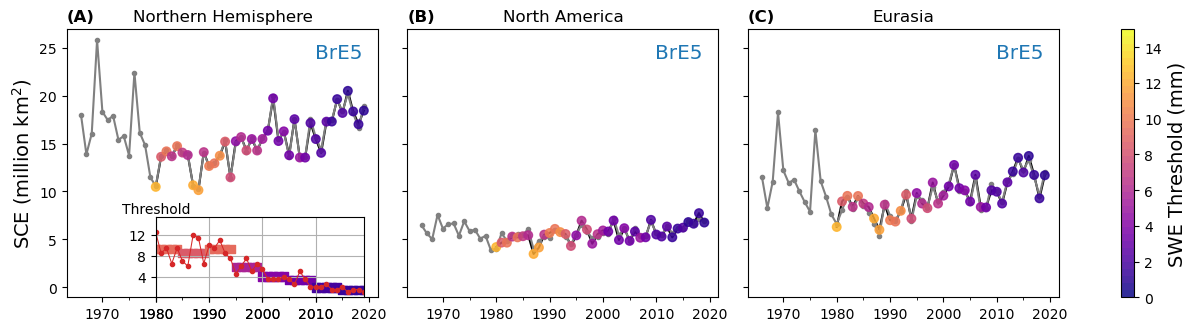

In [ ]:
def Figure_2(month, lmm=[40,90]):
    
    print(mname[month])
    mstr = str(month).zfill(2)

    ### /// Set up axes
    fig = plt.figure(figsize=(16, 6))
    gs = mpl.gridspec.GridSpec(2, 9, height_ratios=[2, 1], wspace=0.35, hspace=0.3)

    ax0 = fig.add_subplot(gs[0, 0:3])
    ax0.set_title('(A)', loc='left', fontweight='bold')
    ax1 = fig.add_subplot(gs[0, 3:6], sharey=ax0)
    ax1.set_title('(B)', loc='left', fontweight='bold')
    ax2 = fig.add_subplot(gs[0, 6:9], sharey=ax0)
    ax2.set_title('(C)', loc='left', fontweight='bold')

    ### /// Get NOAA values

    lmm_str = str(lmm[0])+'_'+str(lmm[1])+'N'
    print(lmm_str)

    NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.{lmm_str}.nc').sortby('time')
    NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, month, ylim = [1966, 2020]) / 1e6
    NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']

    ### /// Calculate optimal threshold for brERA5
    opt_E5, _ = load_calc_optimal('ECMWF.ERA5', month, lmm)

    ### /// Plot main figure 

    for region,ax in zip(['NH', 'NAm', 'Eur'], [ax0,ax1,ax2]):
        opt_E5[region].plot(x='year', ax=ax, color='k') 
        NOAA_ref[region].plot(x='year', ax=ax, label='NOAA CDR', color='grey', marker='.')
        vals = ax.scatter(opt_E5.year, opt_E5[region], 
                        c=opt_E5['threshold'], s=38, zorder=3, cmap=cmap, norm=norm, alpha=0.85)
        
        ### /// Decorate axes
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.set_xticks(range(1970, 2020+1, 10))
        ax.set_xticks(range(1970, 2020, 5), minor=True)

    ### /// Inset plot
    ### /// Calculate 5-year means and plot as overlay
    ylims = ax0.get_ylim()
    new_ymin = np.array([ylims[0],(opt_E5['NH'].min().values-0.4*ylims[1])/(1-0.4)]).min()
    ax0.set_ylim(ymin=new_ymin)

    ax_begin = ax0.transLimits.transform((opt_E5.year[0], 0))[0]
    ax_end = ax0.transLimits.transform((opt_E5.year[-1], 0))[0]

    inset_ax = ax0.inset_axes([ax_begin, 0, ax_end-ax_begin, 0.3], transform=ax0.transAxes, facecolor='white', alpha=0)
    inset_ax.set_xlim(xmin=opt_E5.year[0], xmax=opt_E5.year[-1])
    inset_ax.set_yticks([4,8,12])

    inset_ax.set_ylim(ymin=0, ymax=15.5)
    inset_ax.grid(which='both')

    ### /// Plot threshold on inset axes
        
    opt_E5.threshold.plot(x='year', ax=inset_ax, color='tab:red', linewidth=0.75, marker='.')
    print('RMSD:', 'NH', np.round(np.sqrt(np.mean(((opt_E5['NH']-NOAA_ref['NH'])**2).values)),2),
        'mean:', 'NH', np.round(NOAA_ref['NH'].mean().values,2))
    
    elongated = np.nanmean(np.pad(opt_E5.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
    elongated = np.repeat(elongated, 5)

    inset_ax.scatter(opt_E5.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                marker='s', cmap=cmap, norm=norm)

    ### /// Decorate axes
    inset_ax.set_ylabel('')
    inset_ax.set_xlabel('')
    inset_ax.set_title('')

    inset_ax.text(0, 1.1, 'Threshold', transform=inset_ax.transAxes, ha='center', va='center')

    ### /// Label axes
    ax0.set_ylabel('SCE (million km$^2$)',fontsize=14)
    cbar = plt.colorbar(vals, ax=[ax0,ax1,ax2])#,ax3,ax4])
    cbar.set_label('SWE Threshold (mm)', fontsize=14)

    for ax_instance in [ax0,ax1, ax2]:
        plt.text(0.95, 0.95, d_f_dict['ERA5'], fontsize='x-large', ha='right', va='top', color=colours['ERA5'], transform=ax_instance.transAxes)
            
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)

    ax0.set_title('Northern Hemisphere', loc='center', fontsize='large')
    ax1.set_title('North America', loc='center', fontsize='large')
    ax2.set_title('Eurasia', loc='center', fontsize='large')

Figure_2(10)
plt.savefig(f'Fig3.png', bbox_inches='tight', dpi=300)


## Supplementary figures: 

### Fig. S3: 40-60 N instead of 40-90 N

Oct
40_60N
RMSD: NH 0.08 mean: NH 4.48
1980-1984 avg. best-fit threshold: 11.1
2015-2019 avg. best-fit threshold: 2.1
RMSD: NH 0.08 mean: NH 4.48
1980-1984 avg. best-fit threshold: 12.6
2015-2019 avg. best-fit threshold: 3.6
RMSD: NH 0.09 mean: NH 4.48
1980-1984 avg. best-fit threshold: 12.7
2015-2019 avg. best-fit threshold: 2.9


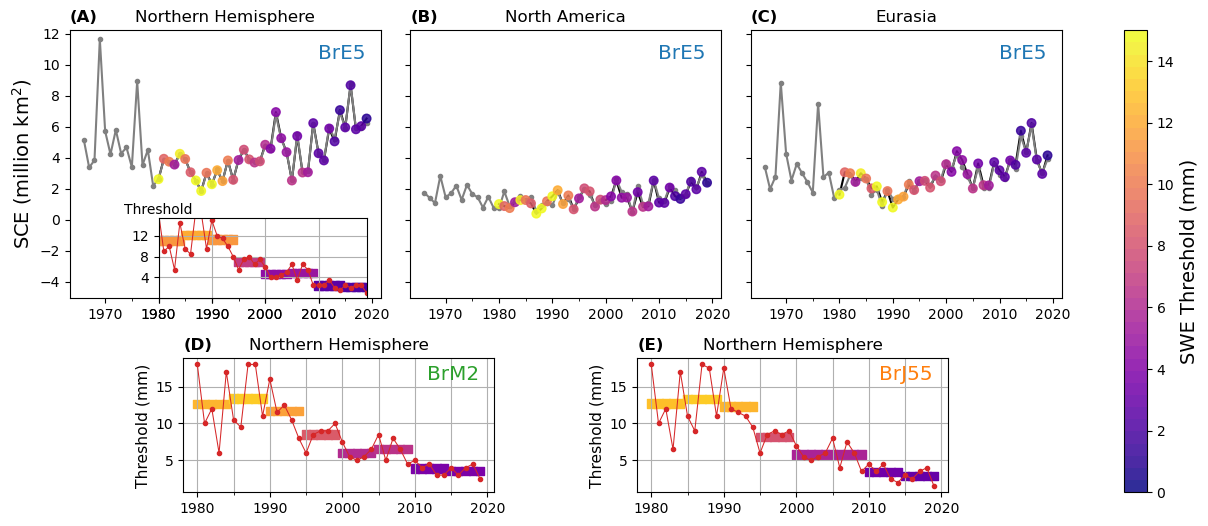

In [ ]:
def Figure_2_full(month, lmm=[40,90]):
    
    print(mname[month])
    mstr = str(month).zfill(2)

    ### /// Set up axes
    fig = plt.figure(figsize=(16, 6))
    gs = mpl.gridspec.GridSpec(2, 9, height_ratios=[2, 1], wspace=0.35, hspace=0.3)

    ax0 = fig.add_subplot(gs[0, 0:3])
    ax0.set_title('(A)', loc='left', fontweight='bold')
    ax1 = fig.add_subplot(gs[0, 3:6], sharey=ax0)
    ax1.set_title('(B)', loc='left', fontweight='bold')
    ax2 = fig.add_subplot(gs[0, 6:9], sharey=ax0)
    ax2.set_title('(C)', loc='left', fontweight='bold')
    ax3 = fig.add_subplot(gs[1, 1:4])
    ax3.set_title('(D)', loc='left', fontweight='bold')
    ax4 = fig.add_subplot(gs[1, 5:8], sharey=ax3)
    ax4.set_title('(E)', loc='left', fontweight='bold')

    ### /// NOAA values

    lmm_str = str(lmm[0])+'_'+str(lmm[1])+'N'
    print(lmm_str)

    NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.{lmm_str}.nc').sortby('time')
    NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, month, ylim = [1966, 2020]) / 1e6
    NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']

    ### /// Calculate optimal threshold for brERA5
    opt_E5, err = load_calc_optimal('ECMWF.ERA5', month, lmm)

    ### /// Plot main figure 

    for region,ax in zip(['NH', 'NAm', 'Eur'], [ax0,ax1,ax2]):
        opt_E5[region].plot(x='year', ax=ax, color='k') 
        NOAA_ref[region].plot(x='year', ax=ax, label='NOAA CDR', color='grey', marker='.')
        vals = ax.scatter(opt_E5.year, opt_E5[region], 
                        c=opt_E5['threshold'], s=38, zorder=3, cmap=cmap, norm=norm, alpha=0.85)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.set_xticks(range(1970, 2020+1, 10))
        ax.set_xticks(range(1970, 2020, 5), minor=True)

    ### /// Inset plot
    ### /// Calculate 5-year means and plot as overlay
    ylims = ax0.get_ylim()
    new_ymin = np.array([ylims[0],(opt_E5['NH'].min().values-0.4*ylims[1])/(1-0.4)]).min()
    ax0.set_ylim(ymin=new_ymin)

    ax_begin = ax0.transLimits.transform((opt_E5.year[0], 0))[0]
    ax_end = ax0.transLimits.transform((opt_E5.year[-1], 0))[0]

    inset_ax = ax0.inset_axes([ax_begin, 0, ax_end-ax_begin, 0.3], transform=ax0.transAxes, facecolor='white', alpha=0)
    inset_ax.set_xlim(xmin=opt_E5.year[0], xmax=opt_E5.year[-1])
    inset_ax.set_yticks([4,8,12])

    inset_ax.set_ylim(ymin=0, ymax=15.5)
    inset_ax.grid(which='both')

    ### /// Repeat for other datasets
    for ax_instance,final_data in zip([inset_ax, ax3, ax4], [opt_E5, 
                                                            load_calc_optimal('NASA.MERRA2', month, lmm)[0], 
                                                            load_calc_optimal('JMA.JRA55', month, lmm)[0]]):
        
        final_data.threshold.plot(x='year', ax=ax_instance, color='tab:red', linewidth=0.75, marker='.')
        print('RMSD:', 'NH', np.round(np.sqrt(((final_data['NH']-NOAA_ref['NH'])**2).mean().values),2),
            'mean:', 'NH', np.round(NOAA_ref['NH'].mean().values,2))
        
        elongated = np.nanmean(np.pad(final_data.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)

        print('1980-1984 avg. best-fit threshold:', elongated[0])
        print('2015-2019 avg. best-fit threshold:', elongated[-1])
        ax_instance.scatter(final_data.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)


        ax_instance.set_ylabel('')
        ax_instance.set_xlabel('')
        ax_instance.set_title('')

    ### /// Decorate axes
    for ax in [ax3, ax4]:
        ax.set_xticks(range(1980, 2020+1, 10))
        ax.set_xticks(range(1980, 2020, 5), minor=True)
        ax.grid(which='both')
        ax.set_ylabel('Threshold (mm)', fontsize=14/1.25)

    inset_ax.text(0, 1.1, 'Threshold', transform=inset_ax.transAxes, ha='center', va='center')

    ax0.set_ylabel('SCE (million km$^2$)',fontsize=14)
    cbar = plt.colorbar(vals, ax=[ax0,ax1,ax2,ax3,ax4])
    cbar.set_label('SWE Threshold (mm)', fontsize=14)
    #plt.text(0.95, 0.08, mname[month], fontsize='x-large', ha='right', color='k', transform=ax2.transAxes)

    for ax_instance,forcing in zip([ax0,ax1, ax2, ax3, ax4], ['ERA5', 'ERA5', 'ERA5', 'MERRA2', 'JRA55']):
        plt.text(0.95, 0.95, d_f_dict[forcing], fontsize='x-large', ha='right', va='top', color=colours[forcing], transform=ax_instance.transAxes)
            
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)

    ax0.set_title('Northern Hemisphere', loc='center', fontsize='large')
    ax1.set_title('North America', loc='center', fontsize='large')
    ax2.set_title('Eurasia', loc='center', fontsize='large')
    ax3.set_title('Northern Hemisphere', loc='center', fontsize='large')
    ax4.set_title('Northern Hemisphere', loc='center', fontsize='large')


Figure_2_full(10, [40,60])
plt.savefig(f'FigS3.png', bbox_inches='tight', dpi=300)


# Figure 4 -- Optimal thresholds for October, both methods

In [ ]:
def load_calc_minerr(forcing, month, lmm, years=[1980, 2020], output_rmsd=False):
    '''Load data and find best-fit thresholds using mis-classification rate.'''

    ### /// Setup
    mstr = str(month).zfill(2)
    mc, model = forcing.split('.')
    lmm_str = str(lmm[0])+'N_'+str(lmm[1])+'N'

    ### /// Load and calculate monthly means
    ds = xr.open_dataset(os.environ['HOME'] + '/L3_Final/{mc}.{model}.reanalysis.weekly.scf_agreements.{lmm_str}.{mstr}.2.nc')
    
    ### /// Get the misclassification rate for NH 
    ### /// Add the number of points that B-TIM and NOAA disagree on, divide by total
    fractions = (ds[['not_BTIM', 'not_NOAA']].to_array('category').sum(('category', 'region')) / ds.to_array('category').sum(('category', 'region')))
    mon_rates = subsample_weight_and_timeav_like_NOAA(100*fractions, month, ylim=years)

    ### /// Step through years, regions and select data /// ###
    ### // We use the best-fit threshold, which minimizes error rate but save NAm and Eurasia data separately /// ###
    if month >=8:
        listsel = [dict([['year',y],
                        ['threshold',t]]) for y in range(years[0], years[1]) for t in [mon_rates.sel(year=y).idxmin(dim='threshold').values.item()]]
    else:
        listsel = [dict([['year',y],
                            ['threshold',t]]) for y in range(years[0]+1, years[1]+1) for t in [mon_rates.sel(year=y).idxmin(dim='threshold').values.item()]]
    
    ### /// Format output
    out_ds = xr.Dataset()
    out_ds['NH'] = xr.concat([mon_rates.sel(di) for di in listsel], 
                             dim='year').rename('err_pct')
    out_ds = out_ds.reset_coords('threshold', drop=False)

    if output_rmsd:
        diff = (ds['not_NOAA'] - ds['not_BTIM']).sum(dim='region')
        diff = subsample_weight_and_timeav_like_NOAA(diff, month, ylim=years)
        diff = xr.concat([diff.sel(di)*25*25/1e6 for di in listsel], dim='year')
    
        return out_ds, diff
    else:
        return out_ds

Oct
1980-1984 avg. best-fit threshold: 9.3
2015-2019 avg. best-fit threshold: 1.4
1980-1984 avg. best-fit threshold: 13.9
2015-2019 avg. best-fit threshold: 3.6
1980-1984 avg. best-fit threshold: 11.6
2015-2019 avg. best-fit threshold: 2.5


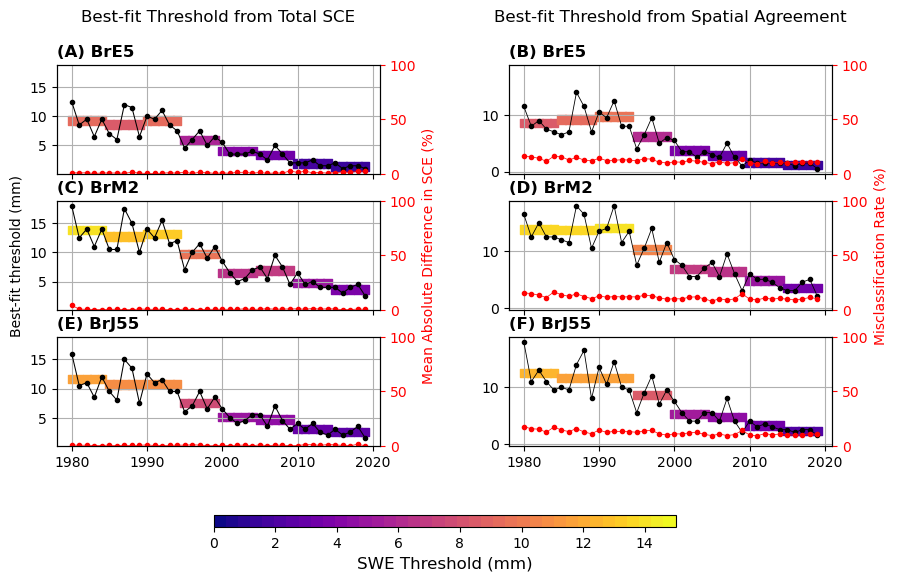

In [ ]:
def Figure_3(month, lmm=[40,90]):

    print(mname[month])

    lmm_str = '{}_{}N'.format(lmm[0], lmm[1])
    NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.{lmm_str}.nc').sortby('time')
    NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, month, ylim = [1966, 2020]) / 1e6
    NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']
    
    ### /// Set up axes
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,6), gridspec_kw={'wspace':0.4, 'hspace':0.25}, sharey='col', sharex=True)
    twin_axs = []

    ### /// Repeat for other datasets
    for ax_instance,fig2 in zip(axs[:,0], [load_calc_optimal('ECMWF.ERA5', month, lmm),
                                                load_calc_optimal('NASA.MERRA2', month, lmm), 
                                                load_calc_optimal('JMA.JRA55', month, lmm)]):
        
        final_data, err = fig2
        final_data.threshold.plot(x='year', ax=ax_instance, color='black', linewidth=0.75, marker='.')
        
        ### /// Plot error rate
        axs_twin = ax_instance.twinx()
        err.plot(x='year', ax=axs_twin, linewidth=0.5, marker='.', color='red')

        elongated = np.nanmean(np.pad(final_data.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)

        print('1980-1984 avg. best-fit threshold:', elongated[0])
        print('2015-2019 avg. best-fit threshold:', elongated[-1])
        
        ax_instance.scatter(final_data.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)


        ### /// Decorate axes
        ax_instance.set_ylabel('SWE threshold (mm)')
        axs_twin.set_ylim(ymin=0, ymax=100)
        axs_twin.set_title('')
        axs_twin.tick_params(axis='y', colors='red')
        axs_twin.yaxis.label.set_color('red')
        #axs.text(0.98, 0.9, d_f_dict[model], fontsize='large', ha='right', va='top', color=colours[model], transform=axs.transAxes)
        axs_twin.set_ylabel('')

        twin_axs.append(axs_twin)
    
    ### /// Load data and plot best-fit thresholds
    nr=0
    for ax_instance,min_err in zip(axs[:,1], [load_calc_minerr('ECMWF.ERA5', month, lmm),
                                                load_calc_minerr('NASA.MERRA2', month, lmm), 
                                                load_calc_minerr('JMA.JRA55', month, lmm)]):
    
        min_err.threshold.plot(ax=ax_instance, color='black', marker='.', linewidth=0.6)

        ### /// Add five-year mean
        elongated = np.nanmean(np.pad(min_err.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)
        levs = ax_instance.scatter(min_err.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                            marker='s', cmap=cmap, norm=norm)
        
        ### /// Plot error rate
        axs_twin = ax_instance.twinx()
        min_err.NH.plot(ax=axs_twin, color='red', marker='.', linewidth=0.5)

        ### /// Decorate axes
        ax_instance.set_ylabel('SWE threshold (mm)')
        axs_twin.set_ylim(ymin=0, ymax=100)
        axs_twin.set_title('')
        axs_twin.tick_params(axis='y', colors='red')
        axs_twin.yaxis.label.set_color('red')
        #axs.text(0.98, 0.9, d_f_dict[model], fontsize='large', ha='right', va='top', color=colours[model], transform=axs.transAxes)
        axs_twin.set_ylabel('')
        
        twin_axs.append(axs_twin)

        nr+=1

    ### /// More axes stuff
    for ax in axs.flat:
        ax.set_ylabel('')
        ax.set_title('')    
        
    axs[1,0].set_ylabel('Best-fit threshold (mm)')

    axs[0,0].set_title('(A) BrE5', loc='left', fontweight='bold')
    axs[0,1].set_title('(B) BrE5', loc='left', fontweight='bold')
    axs[1,0].set_title('(C) BrM2', loc='left', fontweight='bold')
    axs[1,1].set_title('(D) BrM2', loc='left', fontweight='bold')
    axs[2,0].set_title('(E) BrJ55', loc='left', fontweight='bold')
    axs[2,1].set_title('(F) BrJ55', loc='left', fontweight='bold')

    for ax in axs.flat:
        ax.grid(which='both')
        ax.set_xlabel('')
        ax.set_ylim(ymax=max(15.5, ax.get_ylim()[1]))

    twin_axs[1].set_ylabel('Mean Absolute Difference in SCE (%)')
    twin_axs[4].set_ylabel('Misclassification Rate (%)') 
    
    axs[0,0].set_title('Best-fit Threshold from Total SCE\n\n')
    axs[0,1].set_title('Best-fit Threshold from Spatial Agreement\n\n')

    cbar = plt.colorbar(levs, ax=axs, orientation='horizontal', aspect=40, fraction=0.025)#,ax3,ax4])
    cbar.set_label('SWE Threshold (mm)', fontsize='large')

Figure_3(10, [40,90])
plt.savefig('Fig4.png', dpi=300, bbox_inches='tight')


## Supplementary figures: 
### [Not included in Elias Chereque et al. 2025]: Figure 3 for (40-60 N) instead of (40-90 N)

Nov
1980-1984 avg. best-fit threshold: 6.3
2015-2019 avg. best-fit threshold: 1.2
1980-1984 avg. best-fit threshold: 7.1
2015-2019 avg. best-fit threshold: 2.5
1980-1984 avg. best-fit threshold: 8.3
2015-2019 avg. best-fit threshold: 1.6


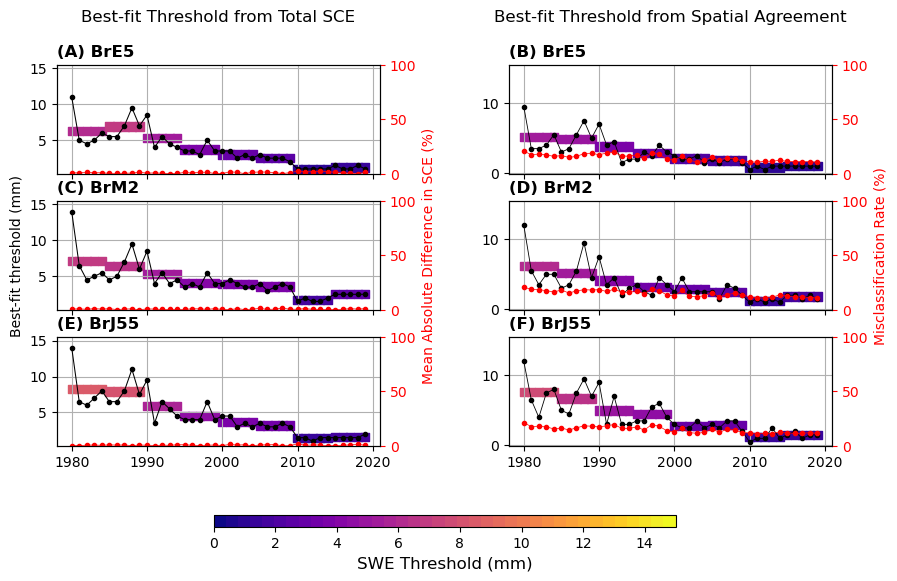

In [14]:
Figure_3(11, [40,60])


# Figure 5 -- Summary of best-fit thresholds across Sept-March 

In this section, we produce Figure 4 from the paper, with additional visualizations for the second method of finding best-fit thresholds.

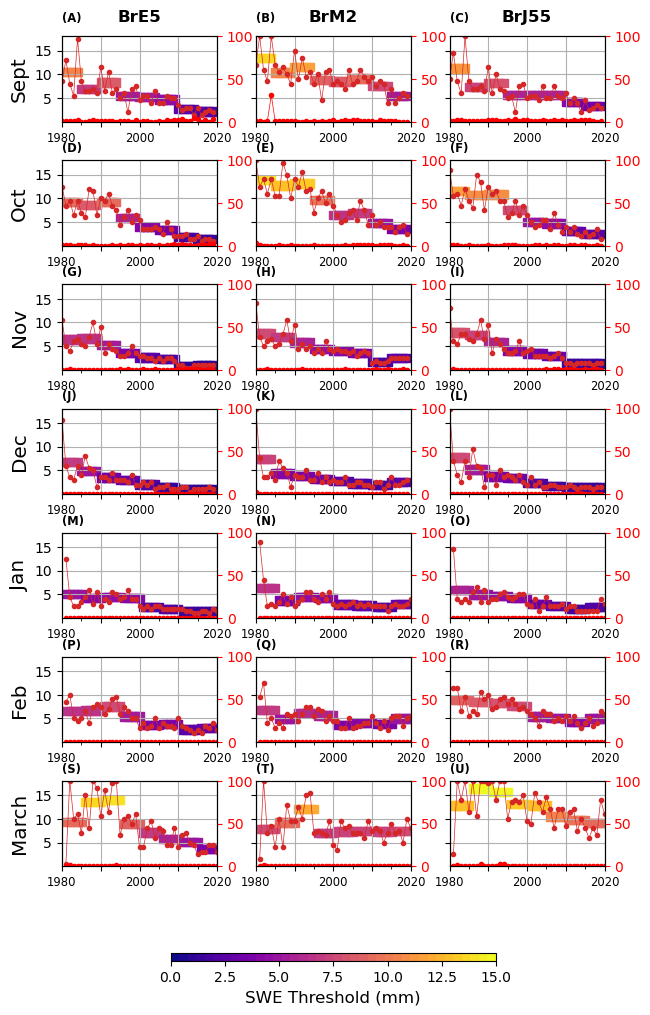

In [ ]:
### BEGIN ###
window = 1
lmm = [40,90]

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(7,14), sharey=True, gridspec_kw={'wspace':0.25, 'hspace':0.45})
letters = iter(['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)', '(M)', '(N)', '(O)', '(P)', '(Q)', '(R)', '(S)', '(T)', '(U)', '(V)'])


for nm,m in enumerate([
                    ['Sept', 9], 
                    ['Oct', 10],
                    ['Nov', 11],
                    ['Dec', 12],
                    ['Jan', 1],
                    ['Feb', 2],
                    ['March', 3],
                    ]):
    
    for nf,forcing in enumerate(['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']):
    
        ### NSIDC values

        NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.40_90N.nc').sortby('time')
        NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, m[1], ylim = [1966, 2020]) / 1e6
        NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']
        
        ### Calculate optimal threshold for brERA5
        opt, err = load_calc_optimal(forcing, m[1], lmm)        

        ### RMSD calculation
        NH_rmsd = np.round((np.sqrt(((opt['NH']-NOAA_ref['NH'])**2).mean()).values), 2)

        ### Design plots
        axs[nm,nf].set_ylim(ymin=0, ymax=18)
        axs[nm,nf].set_xlim(xmin=1980, xmax=2020)
        axs[nm,nf].set_yticks([5, 10, 15])
        axs[nm,nf].set_xticks([1980, 1990, 2000, 2010, 2020], labels=['1980', '', '2000', '', '2020'], fontsize='small')
        axs[nm,nf].set_xticks([1985, 1995, 2005, 2015], minor=True)
        #if NH_rmsd > 0.15:
        # axs[nm,nf].text(0.98, 1.01, f'RMSD={NH_rmsd}', transform=axs[nm,nf].transAxes, ha='right', va='bottom', color='red', fontsize='x-small')

        ### Plot threshold data
        axs[nm,nf].plot(opt.year, opt.threshold, color='tab:red', linewidth=0.5, marker='.')
    
        ### Plot 5-year means
        elongated = np.nanmean(np.pad(opt.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)
        levs = axs[nm,nf].scatter(opt.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)

        axs[nm,nf].set_ylabel('')
        axs[nm,nf].set_xlabel('')
        axs[nm, nf].set_title(next(letters), loc='left', fontsize='small', fontweight='bold')
        
        axs[nm,0].set_ylabel(m[0], fontsize='x-large')

        ### Plot error
        axs_twin = axs[nm,nf].twinx()
        err.plot(x='year', ax=axs_twin, linewidth=0.5, marker='.', color='red')

        axs_twin.set_ylim(ymin=0, ymax=100)
        axs_twin.set_title('')
        axs_twin.tick_params(axis='y', colors='red')
        axs_twin.yaxis.label.set_color('red')
        axs_twin.set_ylabel('')
        
        if nm == 0:
            axs[nm, nf].set_title(d_f_dict[forcing.split('.')[1]], pad=1.75*mpl.rcParams['axes.titlepad'], fontweight='bold')

for ax in axs.flat:
    ax.grid(which='major')
    
cbar = plt.colorbar(levs, ax=axs, orientation='horizontal', aspect=40, shrink=0.6, pad=0.08)#,ax3,ax4])
cbar.set_label('SWE Threshold (mm)', fontsize='large')
plt.savefig('Fig4.png', bbox_inches='tight', dpi=300)


## Supplementary figures: 

### [Not included in Elias Chereque et al. 2025]: Best-fit thresholds by second method

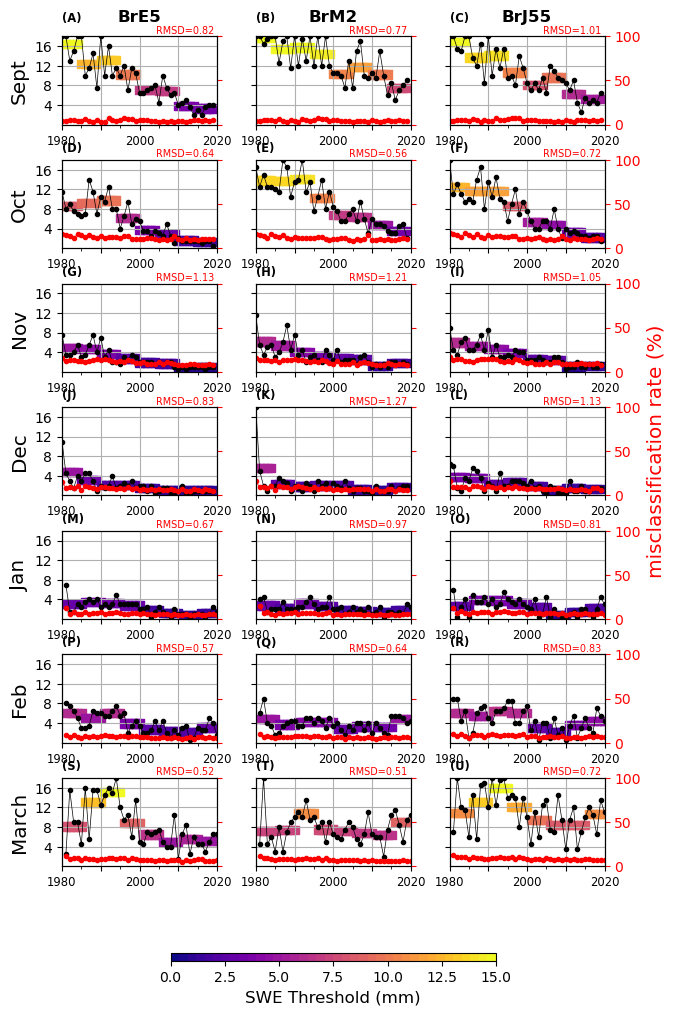

In [ ]:
### BEGIN ###
window = 1
lmm = [40,90]

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(7,14), sharey=True, gridspec_kw={'wspace':0.25, 'hspace':0.4})
letters = iter(['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)', '(M)', '(N)', '(O)', '(P)', '(Q)', '(R)', '(S)', '(T)', '(U)', '(V)'])


for nm,m in enumerate([
                    ['Sept', 9], 
                    ['Oct', 10],
                    ['Nov', 11],
                    ['Dec', 12],
                    ['Jan', 1],
                    ['Feb', 2],
                    ['March', 3],
                    ]):
    
    for nf,forcing in enumerate(['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']):

        
        ### Calculate optimal threshold for brERA5
        opt, diff = load_calc_minerr(forcing, m[1], lmm, output_rmsd=True)        

        NH_rmsd = np.round(np.sqrt(((diff)**2).mean()).values, 2)
        axs[nm,nf].text(0.98, 1.01, f'RMSD={NH_rmsd}', transform=axs[nm,nf].transAxes, ha='right', va='bottom', color='red', fontsize='x-small')
        
        ### Design plots
        axs[nm,nf].set_ylim(ymin=0, ymax=18)
        axs[nm,nf].set_xlim(xmin=1980, xmax=2020)
        axs[nm,nf].set_yticks([4,8,12,16])
        axs[nm,nf].set_xticks([1980, 1990, 2000, 2010, 2020], labels=['1980', '', '2000', '', '2020'], fontsize='small')
        axs[nm,nf].set_xticks([1985, 1995, 2005, 2015], minor=True)

        ### misclassification rate
        ax_twin = axs[nm,nf].twinx()
        opt.NH.plot(ax=ax_twin, color='red', marker='.', linewidth=0.5)

        ax_twin.set_title('')
        ax_twin.set_ylabel('')
        ax_twin.set_ylim(ymin=0, ymax=100)
        ax_twin.yaxis.label.set_color('red')
        ax_twin.tick_params(axis='y', colors='red')

        if (nf == 2) and (nm==3):
            ax_twin.set_ylabel('misclassification rate (%)', fontsize='x-large')
        if nf != 2:
            ax_twin.set_yticklabels([])

        ### Plot threshold data
        axs[nm,nf].plot(opt.year, opt.threshold, color='k', linewidth=0.5, marker='.')
    
        ### Plot 5-year means
        elongated = np.nanmean(np.pad(opt.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)
        levs = axs[nm,nf].scatter(opt.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)

        axs[nm,nf].set_ylabel('')
        axs[nm,nf].set_xlabel('')
        axs[nm, nf].set_title(next(letters), loc='left', fontsize='small', fontweight='bold')
        
        axs[nm,0].set_ylabel(m[0], fontsize='x-large')

        if nm == 0:
            axs[nm, nf].set_title(d_f_dict[forcing.split('.')[1]], pad=1.75*mpl.rcParams['axes.titlepad'], fontweight='bold')

for ax in axs.flat:
    ax.grid(which='major')
cbar = plt.colorbar(levs, ax=axs, orientation='horizontal', aspect=40, shrink=0.6, pad=0.08)#,ax3,ax4])
cbar.set_label('SWE Threshold (mm)', fontsize='large')
plt.savefig('FigS4.png', dpi=300, bbox_inches='tight')


### Figure S4: 40-60N, first method, all months

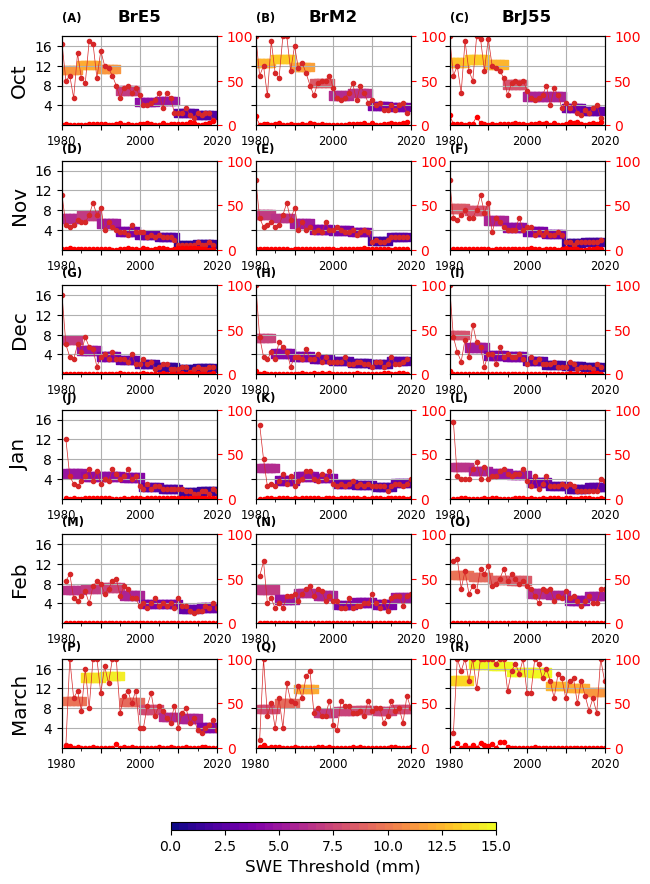

In [ ]:
### BEGIN ###
window = 1
lmm = [40,60]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(7,12), sharey=True, gridspec_kw={'wspace':0.25, 'hspace':0.4})
letters = iter(['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)', '(M)', '(N)', '(O)', '(P)', '(Q)', '(R)', '(S)', '(T)', '(U)', '(V)'])


for nm,m in enumerate([
                    ['Oct', 10],
                    ['Nov', 11],
                    ['Dec', 12],
                    ['Jan', 1],
                    ['Feb', 2],
                    ['March', 3],
                    ]):
    
    for nf,forcing in enumerate(['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']):
    
        ### NSIDC values

        NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.40_60N.nc').sortby('time')
        NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, m[1], ylim = [1966, 2020]) / 1e6
        NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']
        
        ### Calculate optimal threshold for brERA5
        opt, err = load_calc_optimal(forcing, m[1], lmm)        

        ### RMSD calculation
        NH_rmsd = np.round(np.sqrt(((opt['NH']-NOAA_ref['NH'])**2).mean().values), 2)

        ### Design plots
        axs[nm,nf].set_ylim(ymin=0, ymax=18)
        axs[nm,nf].set_xlim(xmin=1980, xmax=2020)
        axs[nm,nf].set_yticks([4,8,12,16])
        axs[nm,nf].set_xticks([1980, 1990, 2000, 2010, 2020], labels=['1980', '', '2000', '', '2020'], fontsize='small')
        axs[nm,nf].set_xticks([1985, 1995, 2005, 2015], minor=True)
        #if NH_rmsd > 0.15:
        # axs[nm,nf].text(0.98, 1.01, f'RMSD={NH_rmsd}', transform=axs[nm,nf].transAxes, ha='right', va='bottom', color='red', fontsize='x-small')

        ### Plot threshold data
        axs[nm,nf].plot(opt.year, opt.threshold, color='tab:red', linewidth=0.5, marker='.')
    
        ### Plot 5-year means
        elongated = np.nanmean(np.pad(opt.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)
        levs = axs[nm,nf].scatter(opt.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)

        axs[nm,nf].set_ylabel('')
        axs[nm,nf].set_xlabel('')
        axs[nm, nf].set_title(next(letters), loc='left', fontsize='small', fontweight='bold')
        
        axs[nm,0].set_ylabel(m[0], fontsize='x-large')

        if nm == 0:
            axs[nm, nf].set_title(d_f_dict[forcing.split('.')[1]], pad=1.75*mpl.rcParams['axes.titlepad'], fontweight='bold')

        ### Plot error
        axs_twin = axs[nm,nf].twinx()
        err.plot(x='year', ax=axs_twin, linewidth=0.5, marker='.', color='red')

        axs_twin.set_ylim(ymin=0, ymax=100)
        axs_twin.set_title('')
        axs_twin.tick_params(axis='y', colors='red')
        axs_twin.yaxis.label.set_color('red')
        axs_twin.set_ylabel('')
        
for ax in axs.flat:
    ax.grid(which='major')
cbar = plt.colorbar(levs, ax=axs, orientation='horizontal', aspect=40, shrink=0.6, pad=0.08)#,ax3,ax4])
cbar.set_label('SWE Threshold (mm)', fontsize='large')


### FIugre S5: April, May, June best-fit thresholds

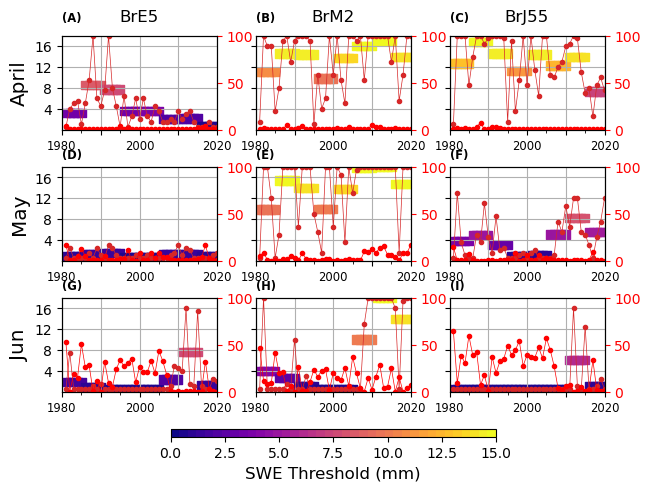

In [ ]:
### BEGIN ###
window = 1
lmm = [40,90]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7,14*3/7), sharey=True, gridspec_kw={'wspace':0.25, 'hspace':0.4})
letters = iter(['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)', '(M)', '(N)', '(O)', '(P)', '(Q)', '(R)', '(S)', '(T)', '(U)', '(V)'])


for nm,m in enumerate([
                    ['April', 4],
                    ['May', 5], 
                    ['Jun', 6]
                        ]):
    for nf,forcing in enumerate(['ECMWF.ERA5', 'NASA.MERRA2', 'JMA.JRA55']):
    
        
        ### NSIDC values

        NOAA_ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_SCE.weekly.40_90N.nc').sortby('time')
        NOAA_ref = subsample_weight_and_timeav_like_NOAA(NOAA_ref, m[1], ylim = [1966, 2020]) / 1e6
        NOAA_ref['NH'] = NOAA_ref['Eur'] + NOAA_ref['NAm']
        
        ### Calculate optimal threshold for brERA5
        opt, err = load_calc_optimal(forcing, m[1], lmm)        

        ### RMSD calculation
        NH_rmsd = np.round(np.sqrt(((opt['NH']-NOAA_ref['NH'])**2).mean().values), 2)

        ### Design plots
        axs[nm,nf].set_ylim(ymin=0, ymax=18)
        axs[nm,nf].set_xlim(xmin=1980, xmax=2020)
        axs[nm,nf].set_yticks([4,8,12,16])
        axs[nm,nf].set_xticks([1980, 1990, 2000, 2010, 2020], labels=['1980', '', '2000', '', '2020'], fontsize='small')
        axs[nm,nf].set_xticks([1985, 1995, 2005, 2015], minor=True)
        # if NH_rmsd > 0.15:
        #     axs[nm,nf].text(0.98, 1.01, f'RMSD={NH_rmsd}', transform=axs[nm,nf].transAxes, ha='right', va='bottom', color='red', fontsize='x-small')

        ### Plot threshold data
        axs[nm,nf].plot(opt.year, opt.threshold, color='tab:red', linewidth=0.5, marker='.')
    
        ### Plot 5-year means
        elongated = np.nanmean(np.pad(opt.threshold, 1//2, mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
        elongated = np.repeat(elongated, 5)
        levs = axs[nm,nf].scatter(opt.year, elongated[1//2:len(elongated)-1//2], c=elongated[1//2:len(elongated)-1//2], 
                    marker='s', cmap=cmap, norm=norm)

        axs[nm,nf].set_ylabel('')
        axs[nm,nf].set_xlabel('')
        axs[nm, nf].set_title(next(letters), loc='left', fontsize='small', fontweight='bold')
        
        axs[nm,0].set_ylabel(m[0], fontsize='x-large')

        if nm == 0:
            axs[nm, nf].set_title(d_f_dict[forcing.split('.')[1]], pad=1.75*mpl.rcParams['axes.titlepad'])

        ### Plot error
        axs_twin = axs[nm,nf].twinx()
        err.plot(x='year', ax=axs_twin, linewidth=0.5, marker='.', color='red')

        axs_twin.set_ylim(ymin=0, ymax=100)
        axs_twin.set_title('')
        axs_twin.tick_params(axis='y', colors='red')
        axs_twin.yaxis.label.set_color('red')
        axs_twin.set_ylabel('')

for ax in axs.flat:
    ax.grid(which='major')       
cbar = plt.colorbar(levs, ax=axs, orientation='horizontal', aspect=40, shrink=0.6, pad=0.08)#,ax3,ax4])
cbar.set_label('SWE Threshold (mm)', fontsize='large')
plt.savefig('FigS5.png', dpi=300, bbox_inches='tight')